# Predicting Future Sales

In [1]:
# Environment Setup
import numpy    as np
import pandas   as pd
import seaborn  as sns
import matplotlib.pyplot as plt
import sklearn  as skl
import datetime

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import linear_model    # LogisticRegression
from sklearn import set_config

In [2]:
# Loading datasets
df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
items_cat = pd.read_csv('item_categories.csv')


## Data Cleaning


## Data Pre-processing

In [3]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
# Converting the date from string to data object for convenient sorting
df_train['date'] = [datetime.date(int(x.split('.')[2]),int(x.split('.')[1]), int(x.split('.')[0])) for x in df_train['date']]
df_train['date']

0          2013-01-02
1          2013-01-03
2          2013-01-05
3          2013-01-06
4          2013-01-15
              ...    
2935844    2015-10-10
2935845    2015-10-09
2935846    2015-10-14
2935847    2015-10-22
2935848    2015-10-03
Name: date, Length: 2935849, dtype: object

In [5]:
# analysis
analysis = df_train.copy()

## day sales in rubles
analysis['day_sales'] = [int(p*q) for p, q in zip(analysis.item_price, analysis.item_cnt_day)]

## month sales in rubles
month_sales = np.array(analysis[['date_block_num', 'day_sales']].groupby(['date_block_num']).sum()['day_sales'])
analysis['month_sales'] = month_sales[analysis['date_block_num']]
analysis.head()

## Extracting item and category names
name_id = {x.at['item_id']: (x.at['item_name'], x.at['item_category_id']) for ix, x in items.iterrows()}
analysis['item_name'] = [name_id[x][0] for x in analysis['item_id']]
analysis['item_category_id'] = [name_id[x][1] for x in analysis['item_id']]
cat_id = {x.at['item_category_id']: x.at['item_category_name'] for ix, x in items_cat.iterrows()}
analysis['item_category'] = [cat_id[x] for x in analysis['item_category_id']]

## extracting shop names
shop_name = {x.at['shop_id']: x.at['shop_name'] for ix, x in shops.iterrows()}
analysis['shop_name'] = [shop_name[x] for x in analysis['shop_id']]

In [6]:
# shop_item_cnt_month - how many of the item pieces was sold in the given shop during the month date-block? I think this is our target.
grp = ['shop_id', 'item_id', 'date_block_num']
analysis['shop_item_cnt_month'] = analysis[['date_block_num', 'item_cnt_day', 'item_id', 'shop_id']].groupby(grp).transform('sum')

# ANALYSIS

In [7]:
plt.figure(figsize=(15,6))
ax = plt.subplot()
monthly_sales = sns.barplot(x=analysis.date_block_num, y=analysis.month_sales, ax = ax)
monthly_sales.set_title("Monthly sales (RUB)")
monthly_sales.set_yticks(np.arange(0, analysis.month_sales.max() + 1, analysis.month_sales.max()/4))
monthly_sales.set(ylabel = "(Million)")

ms_line = sns.lineplot(x=analysis.date_block_num , y=analysis.month_sales, ax = ax, color='green')

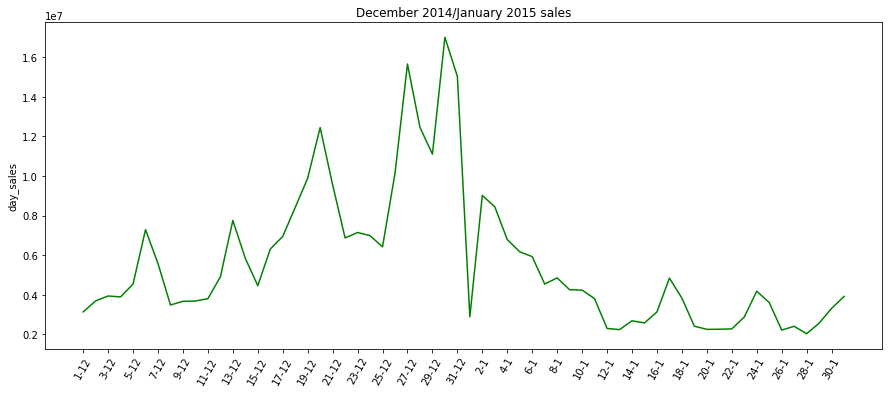

In [8]:
plt.figure(figsize=(15,6))
russianchristmas = analysis.loc[analysis["date_block_num"].isin([23, 24])].groupby(['date'])['day_sales'].sum().reset_index(drop=False)
#x = [x[:2] for x in dec2015.date]
ruschr = sns.lineplot(x=[f"{x.day}-{x.month}" for x in russianchristmas.date], y=russianchristmas.day_sales, color = 'green')
ruschr.set_xticks(ruschr.get_xticks()[::2])
ruschr.set_title("December 2014/January 2015 sales")
plt.xticks(rotation=60)
plt.show()

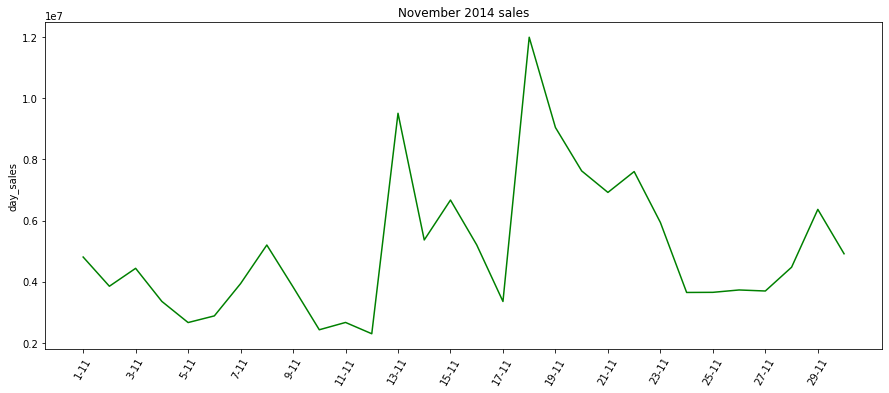

In [9]:
plt.figure(figsize=(15,6))
nov2014 = analysis.loc[analysis["date_block_num"] == 22].groupby(['date'])['day_sales'].sum().reset_index(drop=False)
#x = [x[:2] for x in dec2015.date]
nov2014plot = sns.lineplot(x=[f"{x.day}-{x.month}" for x in nov2014.date], y=nov2014.day_sales, color = 'green')
nov2014plot.set_xticks(nov2014plot.get_xticks()[::2])
nov2014plot.set_title("November 2014 sales")
plt.xticks(rotation=60)
plt.show()

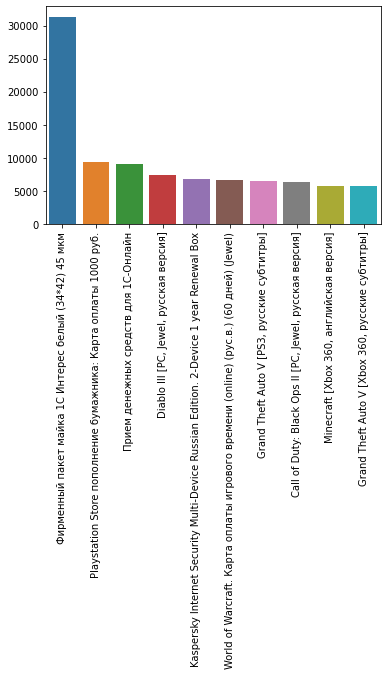

In [10]:
most_popular_items = analysis.item_name.value_counts()[:10]
plt.xticks(rotation = 90)
mpi = sns.barplot(x=most_popular_items.keys(), y=most_popular_items.values)
# First place is a t-shirt packet

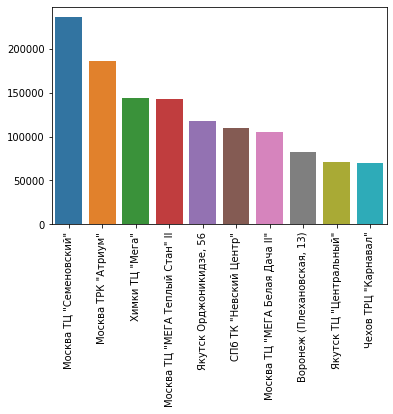

In [11]:
most_popular_shops = analysis.shop_name.value_counts()[:10]
plt.xticks(rotation = 90)
mps = sns.barplot(x=most_popular_shops.keys(), y=most_popular_shops.values)
#top 1, 2, 4, 7 are located in Moscow

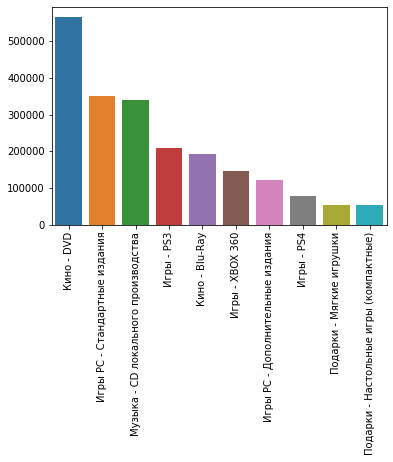

In [12]:
most_popular_cats = analysis.item_category.value_counts()[:10]
plt.xticks(rotation = 90)
mpc = sns.barplot(x=most_popular_cats.keys(), y=most_popular_cats.values)
# Movies, PC games, Music, PS3 games

In [13]:
train = analysis[analysis['item_id'].isin(df_test['item_id'])].reset_index(drop=True)

In [14]:


train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446006 entries, 0 to 1446005
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   date                 1446006 non-null  object 
 1   date_block_num       1446006 non-null  int64  
 2   shop_id              1446006 non-null  int64  
 3   item_id              1446006 non-null  int64  
 4   item_price           1446006 non-null  float64
 5   item_cnt_day         1446006 non-null  float64
 6   day_sales            1446006 non-null  int64  
 7   month_sales          1446006 non-null  int64  
 8   item_name            1446006 non-null  object 
 9   item_category_id     1446006 non-null  int64  
 10  item_category        1446006 non-null  object 
 11  shop_name            1446006 non-null  object 
 12  shop_item_cnt_month  1446006 non-null  float64
dtypes: float64(3), int64(6), object(4)
memory usage: 143.4+ MB


In [15]:
train.shop_item_cnt_month

In [16]:
train['month_sales_cnt'] = train[['date_block_num', 'shop_item_cnt_month']].groupby('date_block_num').transform('sum')

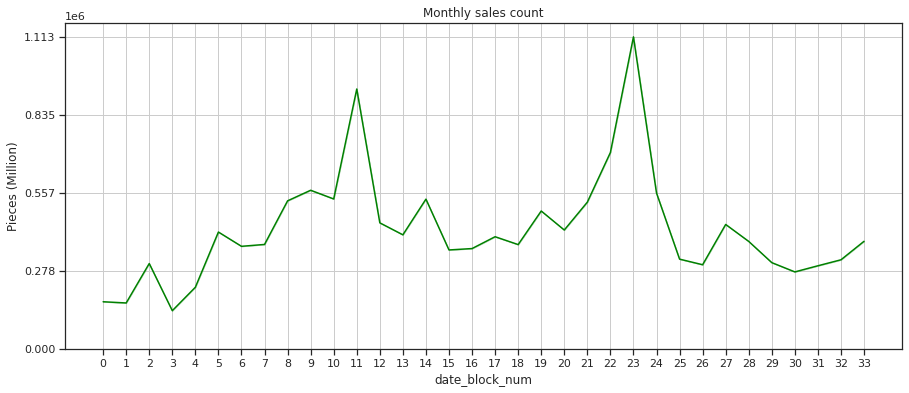

In [17]:
plt.figure(figsize=(15,6))
sns.set(style='ticks')
monthly_count = sns.lineplot(x=train.date_block_num , y=train.month_sales_cnt, color='green')
monthly_count.set_title("Monthly sales count")
monthly_count.set_yticks(np.arange(0, train.month_sales_cnt.max() + 1, train.month_sales_cnt.max()/4))
monthly_count.set_xticks(np.arange(0, 34))
monthly_count.set(ylabel = "Pieces (Million)")
plt.grid()

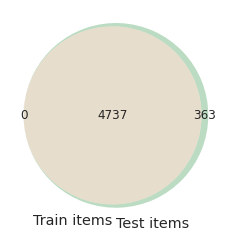

In [18]:
from matplotlib_venn import venn2
venn2([set(train.item_id.unique()), set(df_test.item_id.unique())], set_labels = ('Train items', 'Test items'))
plt.show()

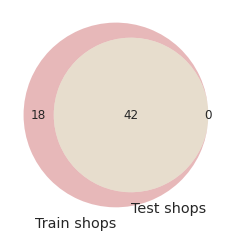

In [19]:
venn2([set(train.shop_id.unique()), set(df_test.shop_id.unique())], set_labels = ('Train shops', 'Test shops'))
plt.show()

### proposals for test features:
- [x] item category ID 
- [x] shop position in popularity (ordinary from 0 to n shops)
- [x] item position in popularity
- [x] category position in popularity
-  shop city?


In [21]:
test = df_test.copy()
test['item_category_id'] = [name_id[x][1] for x in test['item_id']]

In [22]:
def sort_ordinally(dic):
    keys = dic.keys()
    values = dic.values
    last_unique = (0, 0) # (count value, popularity placement)
    order = 0
    for idx, x in enumerate(values):
        if x != last_unique[0]:
            last_unique = (x, order)
            dic[keys[idx]] = order
            order += 1
        else:
            dic[keys[idx]] = last_unique[1]
    return dic

In [23]:
shops_popularity = sort_ordinally(train.shop_id.value_counts())
cats_popularity = sort_ordinally(train.item_category_id.value_counts())
items_popularity = sort_ordinally(train.item_id.value_counts())

In [24]:
test['shop_popularity'] = [shops_popularity[x] for x in test['shop_id']]
test['cat_popularity'] = [cats_popularity[x] if x in cats_popularity else np.NaN for x in test['item_category_id']]
test['item_popularity'] = [items_popularity[x] if x in items_popularity else np.NaN for x in test['item_id']]

In [25]:
# there are 84 entries with new categories and 15246 entries with new items. What to do about NaNs?
print(test.isna().sum())
test.head()

ID                      0
shop_id                 0
item_id                 0
item_category_id        0
shop_popularity         0
cat_popularity         84
item_popularity     15246
dtype: int64


,ID,shop_id,item_id,item_category_id,shop_popularity,cat_popularity,item_popularity
0,0,5,5037,19,28,3.0,239.0
1,1,5,5320,55,28,0.0,NaN
2,2,5,5233,19,28,3.0,574.0
3,3,5,5232,23,28,4.0,886.0
4,4,5,5268,20,28,5.0,NaN


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6debef96-f819-431a-891f-c018cd62f292' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>